In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from statsmodels.tsa.stattools import acf, pacf
from pandas import DataFrame
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from numpy import sqrt 
import math
rcParams['figure.figsize'] = 15, 7

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
dbd = pd.read_csv('datakasusDBD2.csv',  index_col='Tahun',  parse_dates = ['Tahun'], date_parser = dateparse)
print(dbd.head())
dbd.dtypes

            KasusDBD
Tahun               
2012-01-01       436
2012-02-01       493
2012-03-01       519
2012-04-01       482
2012-05-01       573


C:\Users\asus\AppData\Local\Temp\ipykernel_34228\1846689889.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


KasusDBD    int64
dtype: object

In [3]:
ts  = dbd["KasusDBD"] 
ts.head()

Tahun
2012-01-01    436
2012-02-01    493
2012-03-01    519
2012-04-01    482
2012-05-01    573
Name: KasusDBD, dtype: int64

<AxesSubplot:xlabel='Tahun'>

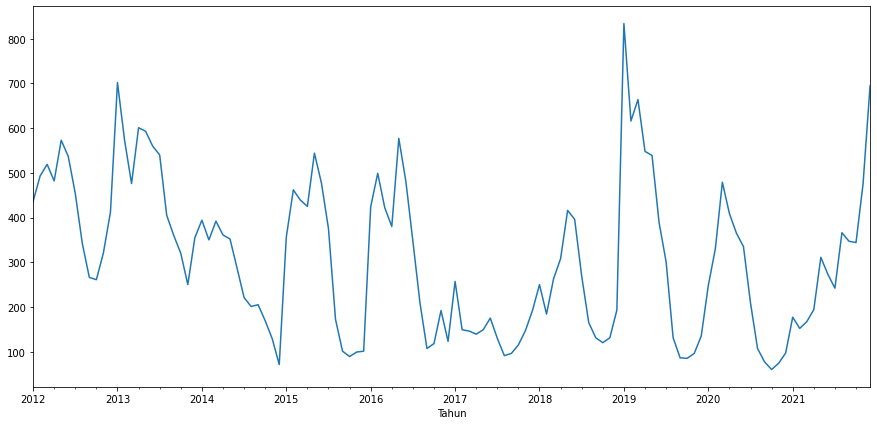

In [4]:
ts.plot()

1. IDENTIFIKASI DATA STASIONER ATAU TIDAK

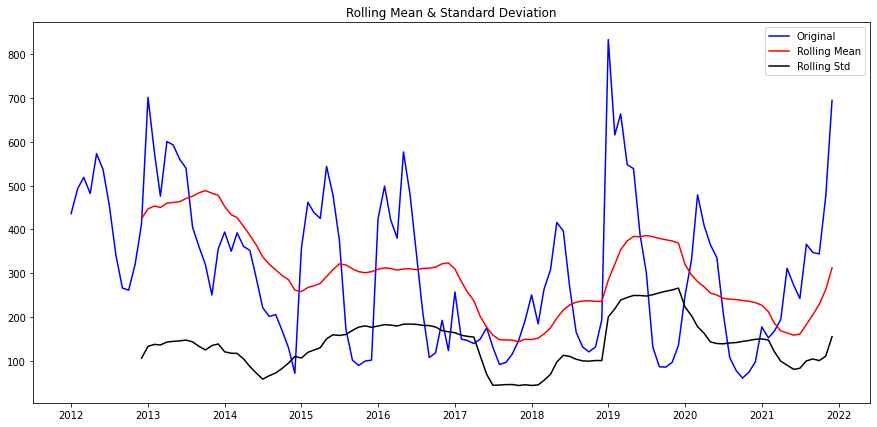

Results of Dickey-Fuller Test:
Test Statistic                  -4.822679
p-value                          0.000049
#Lags Used                       4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [5]:
#CEK STASIONER
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dbdtest = adfuller(timeseries, autolag='AIC')
    dbdoutput = pd.Series(dbdtest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dbdtest[4].items():
        dbdoutput['Critical Value (%s)'%key] = value
    print (dbdoutput)

test_stationarity(ts)

2. MENENTUKAN MODEL 

Text(0.5, 1.0, 'Partial Autocorrelation Function')

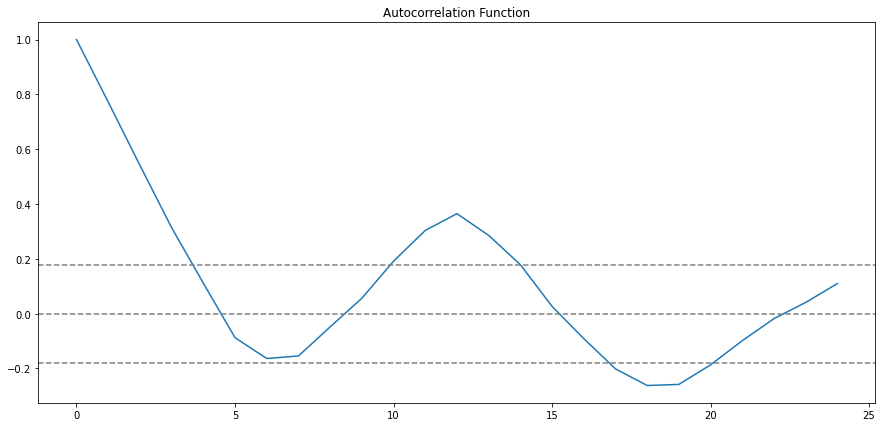

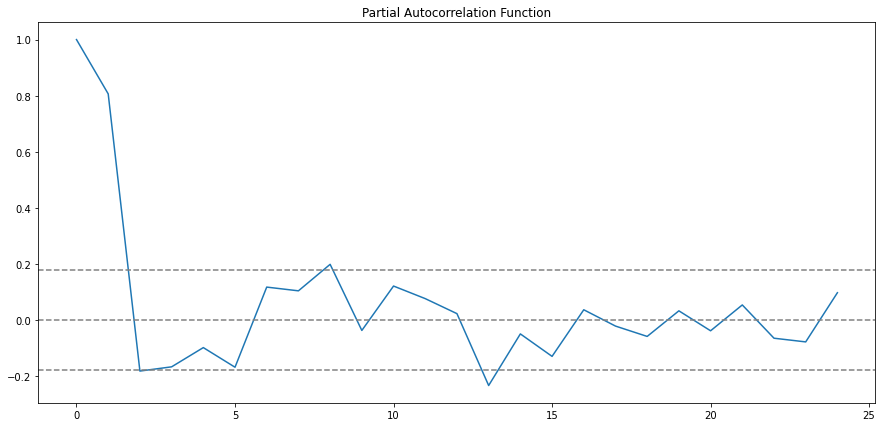

In [6]:

lag_acf = acf(ts, nlags=24)
lag_pacf = pacf(ts, nlags=24, method='ols')

#Plot ACF: 
fig1 = plt.figure()
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
fig2 = plt.figure()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

In [7]:
#model_fit=sm.tsa.statespace.SARIMAX(ts,order=(2,0,0))
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts, order=(2, 0, 0))  
results_AR = model.fit()  
print(results_AR.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               KasusDBD   No. Observations:                  120
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -727.505
Date:                Sat, 30 Jul 2022   AIC                           1463.010
Time:                        23:53:45   BIC                           1474.160
Sample:                    01-01-2012   HQIC                          1467.538
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        320.0596     54.253      5.899      0.000     213.726     426.393
ar.L1          0.9453      0.073     12.956      0.000       0.802       1.088
ar.L2         -0.1796      0.078     -2.305      0.0

In [8]:
predictions_AR = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR)

Tahun
2012-01-01    320.059560
2012-02-01    412.971809
2012-03-01    462.717346
2012-04-01    477.059861
2012-05-01    437.416583
                 ...    
2021-08-01    254.721967
2021-09-01    377.501349
2021-10-01    337.276809
2021-11-01    337.852491
2021-12-01    462.221296
Length: 120, dtype: float64


Text(0.5, 1.0, 'RMSE: 103.8073')

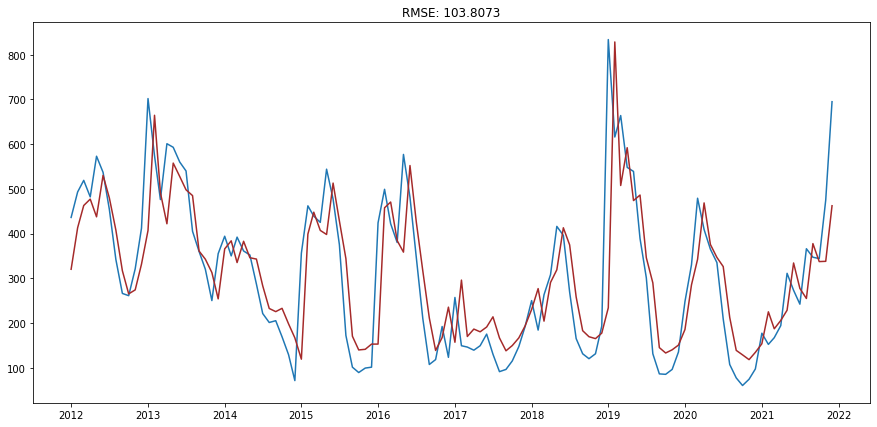

In [9]:
plt.plot(dbd['KasusDBD'])
plt.plot(predictions_AR,color='brown')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_AR-dbd['KasusDBD'])**2)/len(ts)))

In [10]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    me = np.mean(forecast - actual)                               # ME
    mae = np.mean(np.abs(forecast - actual))                      # MAE
    MSE = np.square(np.subtract(actual,forecast)).mean()          #MSE
    RMSE = math.sqrt(MSE)                                         #RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                     # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                               # minmax

    return('MAPE: %.4f'%mape, 
            'ME: %.4f'%me, 
            'MAE %.4f'%mae,
            'MSE: %.4f'%MSE,
            'RMSE: %.4f'%RMSE,
            'CORR: %.4f'%corr, 
            'MINMAX: %.4f'%minmax)

forecast_accuracy(predictions_AR, dbd['KasusDBD'])

C:\Users\asus\AppData\Local\Temp\ipykernel_34228\883026979.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\asus\AppData\Local\Temp\ipykernel_34228\883026979.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\asus\AppData\Local\Temp\ipykernel_34228\883026979.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\asus\AppData\Local\Temp\ipykernel_34228\883026979.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, Non

('MAPE: 30.1861',
 'ME: 0.3441',
 'MAE 71.9069',
 'MSE: 10775.9639',
 'RMSE: 103.8073',
 'CORR: 0.7969',
 'MINMAX: 0.2200')

In [11]:
from pandas.tseries.offsets import DateOffset
future_dates=[dbd.index[-1] + DateOffset(months=x) for x in range(0,5)]
future_datest_dbd=pd.DataFrame(index=future_dates[1:],columns=dbd.columns)

future_datest_dbd.head()

,KasusDBD
2022-01-01,NaN
2022-02-01,NaN
2022-03-01,NaN
2022-04-01,NaN


<AxesSubplot:>

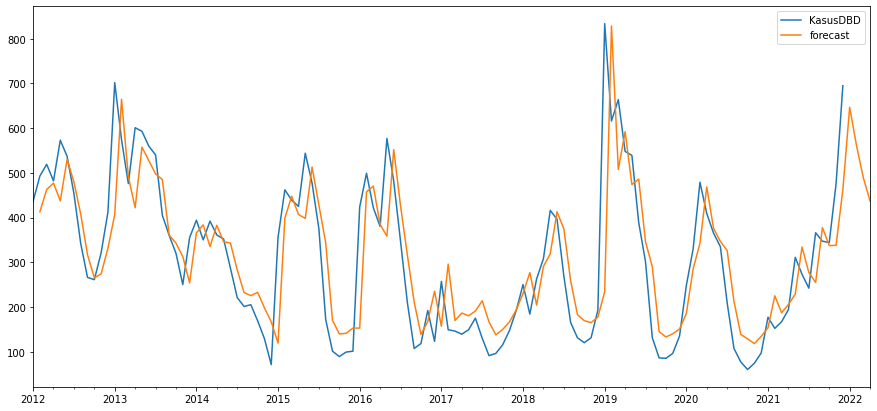

In [12]:
from turtle import color


future_dbd=pd.concat([dbd,future_datest_dbd])

future_dbd['forecast'] = results_AR.predict(start = 1, end = 138, dynamic= False)
future_dbd[['KasusDBD','forecast']].plot()

In [13]:
print(future_dbd[['KasusDBD', 'forecast']].tail(10))

           KasusDBD    forecast
2021-07-01      242  277.202311
2021-08-01      366  254.721967
2021-09-01      347  377.501349
2021-10-01      344  337.276809
2021-11-01      475  337.852491
2021-12-01      695  462.221296
2022-01-01      NaN  646.659020
2022-02-01      NaN  561.462395
2022-03-01      NaN  489.608441
2022-04-01      NaN  436.984395


In [14]:
import pickle
pickle.dump(future_dbd, open('arima_model.pkl','wb'))